In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib

In [6]:
concept_model = tf.keras.models.load_model("sensor_data_to_concept_model.keras")
activity_model = joblib.load("./models/lr_concept_to_activity.pkl")

activity_mapping = joblib.load("./models/activity_mapping.pkl")
activity_reverse_mapping = {v: k for k, v in activity_mapping.items()}

In [7]:
df_sensor = pd.read_csv('./data/final_dataset.csv')
df_windows = pd.read_csv('./data/final_window_labels.csv') 

In [8]:
def extract_window_robust(df_sensor, window_row, time_tolerance=0.5):
    """
    Extract sensor data with time tolerance to handle mismatches.
    """
    user = window_row['user']
    activity = window_row['activity']
    start_time = window_row['start_time']
    end_time = window_row['end_time']
    
    # Get data for this user/activity
    user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                  (df_sensor['activity'] == activity)].copy()
    
    if len(user_activity_data) == 0:
        return None
    
    # Find data within time window with tolerance
    mask = ((user_activity_data['time_s'] >= start_time - time_tolerance) & 
            (user_activity_data['time_s'] <= end_time + time_tolerance))
    
    window_data = user_activity_data[mask]
    
    if len(window_data) < 10:  # Need minimum samples
        return None
    
    # Extract sensor readings
    sensor_data = window_data[['x-axis', 'y-axis', 'z-axis']].values
    
    # Pad or truncate to fixed length (e.g., 100 samples)
    target_length = 60
    if len(sensor_data) > target_length:
        # Randomly sample if too long
        indices = np.random.choice(len(sensor_data), target_length, replace=False)
        sensor_data = sensor_data[indices]
    elif len(sensor_data) < target_length:
        padding = np.tile(sensor_data[-1:], (target_length - len(sensor_data), 1))
        sensor_data = np.vstack([sensor_data, padding])
    
    return sensor_data

def extract_windows_robust(df_sensor, df_windows):
    """
    Extract all windows with robust time matching for 6 concepts.
    """
    X = []
    y_p = []  # periodicity
    y_t = []  # temporal_stability
    y_c = []  # coordination
    y_mi = [] # motion_intensity
    y_vd = [] # vertical_dominance
    y_sp = [] # static_posture
    
    for _, window_row in df_windows.iterrows():
        window_data = extract_window_robust(df_sensor, window_row)
        if window_data is not None:
            X.append(window_data)
            y_p.append(window_row['periodicity'])
            y_t.append(window_row['temporal_stability'])
            y_c.append(window_row['coordination'])
            y_mi.append(window_row['motion_intensity'])
            y_vd.append(window_row['vertical_dominance'])
            y_sp.append(window_row['static_posture'])
    
    return np.array(X), np.array(y_p), np.array(y_t), np.array(y_c), np.array(y_mi), np.array(y_vd), np.array(y_sp)

In [9]:
# lets just do it for for first window
window_row = df_windows.iloc[0]
window_data = extract_window_robust(df_sensor, window_row)

X = np.expand_dims(window_data, axis=0)  # shape (1, time, channels)

print(X.shape)
print("First 5 values")
print(X[0][:5])

print("Last 5 values")
print(X[0][-5:])

(1, 60, 3)
First 5 values
[[ 1.76  0.46 -1.61]
 [ 0.57  1.5  -2.3 ]
 [ 2.56  5.48  5.52]
 [11.73 14.9  17.08]
 [ 9.43  5.01  3.6 ]]
Last 5 values
[[10.61 12.95 -3.72]
 [ 8.2  16.21 -2.96]
 [ 0.99  1.95 -0.65]
 [ 1.31  0.31 -1.92]
 [ 2.07  0.95 -3.99]]


In [ ]:

preds = concept_model.predict(X)

periodicity_pred = np.argmax(preds[0], axis=1)[0]
temporal_stability_pred = np.argmax(preds[1], axis=1)[0]
coordination_pred = np.argmax(preds[2], axis=1)[0]
motion_intensity_pred = preds[3].flatten()[0]
vertical_dominance_pred = preds[4].flatten()[0]

true_periodicity = window_row['periodicity']
true_temporal_stability = window_row['temporal_stability']
true_coordination = window_row['coordination']
true_motion_intensity = window_row['motion_intensity']
true_vertical_dominance = window_row['vertical_dominance']

compare = pd.DataFrame({
    'Concept': ['Periodicity','Temporal_Stability','Coordination','Motion_Intensity','Vertical_Dominance'],
    'Predicted': [periodicity_pred, temporal_stability_pred, coordination_pred, motion_intensity_pred, vertical_dominance_pred],
    'True': [true_periodicity, true_temporal_stability, true_coordination, true_motion_intensity, true_vertical_dominance]
})
print(compare)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
              Concept  Predicted      True
0         Periodicity   2.000000  1.000000
1  Temporal_Stability   1.000000  0.500000
2        Coordination   1.000000  0.500000
3    Motion_Intensity   0.354109  0.316815
4  Vertical_Dominance   0.217238  0.221105
5      Static_Posture   0.000000  0.000000


In [ ]:
concept_vector = np.array([[periodicity_pred,
                            temporal_stability_pred,
                            coordination_pred,
                            motion_intensity_pred,
                            vertical_dominance_pred]])

In [ ]:
predicted_concepts = {
    'periodicity': periodicity_pred,
    'temporal_stability': temporal_stability_pred,
    'coordination': coordination_pred,
    'motion_intensity': motion_intensity_pred,
    'vertical_dominance': vertical_dominance_pred,
}

discrete_columns = ['periodicity', 'temporal_stability', 'coordination']
continuous_columns = ['motion_intensity', 'vertical_dominance']

X_final = np.array([[predicted_concepts[col] for col in discrete_columns + continuous_columns]])

activity_pred_class = activity_model.predict(X_final)[0]
activity_pred_str = activity_reverse_mapping[activity_pred_class]

true_activity_str = window_row['activity']

Predicted Activity: Jogging
True Label: Walking
              Concept  Predicted      True
0         Periodicity   2.000000  1.000000
1  Temporal_Stability   1.000000  0.500000
2        Coordination   1.000000  0.500000
3    Motion_Intensity   0.354109  0.316815
4  Vertical_Dominance   0.217238  0.221105
5      Static_Posture   0.000000  0.000000


The sensor data to concepts model predicted:
              Concept  Predicted      True
0         Periodicity   2.000000  1.000000
1  Temporal_Stability   1.000000  0.500000
2        Coordination   1.000000  0.500000
3    Motion_Intensity   0.354109  0.316815
4  Vertical_Dominance   0.217238  0.221105
5      Static_Posture   0.000000  0.000000




The concepts to true activity label model predicted:
Predicted Activity: Jogging
True Label: Walking






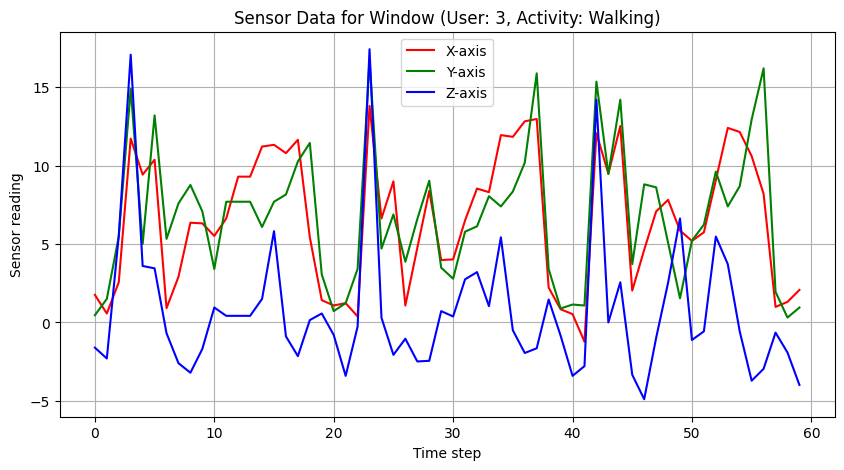

In [20]:
# results

print("The sensor data to concepts model predicted:")
compare = pd.DataFrame({
    'Concept': ['Periodicity','Temporal_Stability','Coordination','Motion_Intensity','Vertical_Dominance','Static_Posture'],
    'Predicted': [periodicity_pred, temporal_stability_pred, coordination_pred, motion_intensity_pred, vertical_dominance_pred, static_posture_pred],
    'True': [window_row['periodicity'], window_row['temporal_stability'], window_row['coordination'], window_row['motion_intensity'], window_row['vertical_dominance'], window_row['static_posture']]
})
print(compare)

print("\n\n\n")

print("The concepts to true activity label model predicted:")
print("Predicted Activity:", activity_pred_str)
print("True Label:", true_activity_str)

print("\n\n\n")

time_steps = X.shape[1]

plt.figure(figsize=(10, 5))
plt.plot(range(time_steps), X[0][:, 0], label='X-axis', color='r')
plt.plot(range(time_steps), X[0][:, 1], label='Y-axis', color='g')
plt.plot(range(time_steps), X[0][:, 2], label='Z-axis', color='b')

plt.title(f"Sensor Data for Window (User: {window_row['user']}, Activity: {window_row['activity']})")
plt.xlabel("Time step")
plt.ylabel("Sensor reading")
plt.legend()
plt.grid(True)
plt.show()
